<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [2]:
import urllib.request
import bs4 as bs

Para este trabajo, el libro elegido es "Viaje al centro de la tierra"

In [3]:
# Descarga del corpus
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag )
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

### **Elección del tamaño de contexto**

Se decidió usar un valor de 100 caracteres ya que creo que permite incluir una o dos frases, lo que proporciona suficiente información para que el modelo aprenda dependencias significativas. A su vez, se busca evitar que las secuencias sean muy extensas y que dificulte la convergencia.

In [4]:
# Tamaño de contexto
max_context_size = 100


# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)


# la longitud de vocabulario de caracteres es:
len(chars_vocab)


# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

### **Tokenización**

De acuerdo al enunciado, la tokenización debe ser por caracteres. Para ello se hace uso del diccionario construido en la celda anterior.

In [5]:
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:1000]

[27,
 8,
 43,
 27,
 58,
 17,
 73,
 38,
 7,
 54,
 17,
 27,
 55,
 72,
 27,
 58,
 8,
 27,
 73,
 39,
 28,
 17,
 27,
 58,
 8,
 27,
 4,
 49,
 47,
 0,
 19,
 27,
 73,
 38,
 27,
 61,
 26,
 17,
 19,
 27,
 8,
 43,
 27,
 14,
 23,
 17,
 56,
 8,
 2,
 17,
 23,
 27,
 43,
 38,
 58,
 8,
 7,
 41,
 23,
 17,
 44,
 32,
 19,
 27,
 8,
 7,
 61,
 23,
 64,
 27,
 20,
 23,
 25,
 14,
 38,
 58,
 39,
 73,
 8,
 7,
 61,
 8,
 27,
 39,
 27,
 2,
 34,
 27,
 30,
 17,
 54,
 39,
 23,
 19,
 27,
 2,
 38,
 61,
 34,
 39,
 58,
 17,
 27,
 8,
 7,
 27,
 8,
 43,
 27,
 7,
 63,
 73,
 8,
 23,
 17,
 27,
 4,
 52,
 27,
 58,
 8,
 27,
 43,
 39,
 27,
 32,
 24,
 7,
 38,
 54,
 57,
 2,
 61,
 23,
 39,
 2,
 2,
 8,
 19,
 27,
 34,
 7,
 39,
 20,
 27,
 58,
 8,
 27,
 43,
 39,
 2,
 27,
 44,
 39,
 43,
 43,
 8,
 2,
 27,
 73,
 25,
 2,
 27,
 61,
 23,
 39,
 58,
 38,
 44,
 38,
 17,
 7,
 39,
 43,
 8,
 2,
 27,
 58,
 8,
 43,
 27,
 41,
 39,
 23,
 23,
 38,
 17,
 27,
 39,
 7,
 61,
 38,
 54,
 34,
 17,
 27,
 58,
 8,
 27,
 30,
 39,
 73,
 41,
 34,
 23,
 54,
 17,
 69,
 2

### **Estructuración del dataset**

In [6]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))


# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]


tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]


tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]


X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [7]:
X.shape

X[0,:10]
y[0,:10]
vocab_size = len(chars_vocab)

### **Callback para calculo de perplejidad**

In [8]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### **Definición del modelo**

Se definió un modelo basado en LSTM. Tiene una capa de embedding para convertir los tokens en vectores, despues una capa recurrente del tipo LSTM y una capa densa con activación softmax.

Cabe aclarar que debido a las limitaciones de recursos en Google Colab, esta fue la única configuración que pude probar.



In [11]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=vocab_size, output_dim=64, input_shape=(None,)))
model_lstm.add(LSTM(200, return_sequences=True))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 64)       │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       212,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 77)       │        15,477 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,405 (907.83 KB)

 Trainable params: 232,405 (907.83 KB)

 Non-trainable params: 0 (0.00 B)

### **Entrenamiento**

Epoch 1/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4857
 mean perplexity: 7.179967191794438 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - loss: 2.4852
Epoch 2/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8935
 mean perplexity: 6.03292619204912 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - loss: 1.8934
Epoch 3/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7211
 mean perplexity: 5.517482834621671 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - loss: 1.7211
Epoch 4/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6093
 mean perplexity: 5.187892626264335 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - loss: 1.6093
Epoch 5/20
1505/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5318
 mean perplexity: 5.147930591391177 

Saved new model!
1506/1506 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - loss: 1.5318
Epoch 6/20
1504/1506 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4771
 mean 

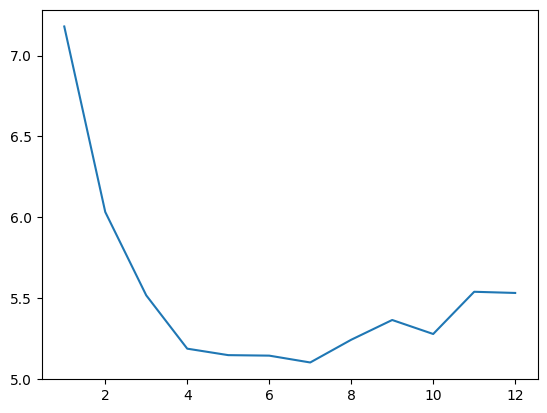

In [12]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)


import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


Como se observa en el gráfico, a partir de la época 9 comienza a existir un overfitting.

Para intentar mejorar los resultados, se podría probar otra configuración agregando una capa adicional de LSTM junto con dropout.

### **Predicción del próximo caracter**

In [13]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [20]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://95192d2338e25c5c28.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://95192d2338e25c5c28.gradio.live


Se tomaron capturas de algunas pruebas:

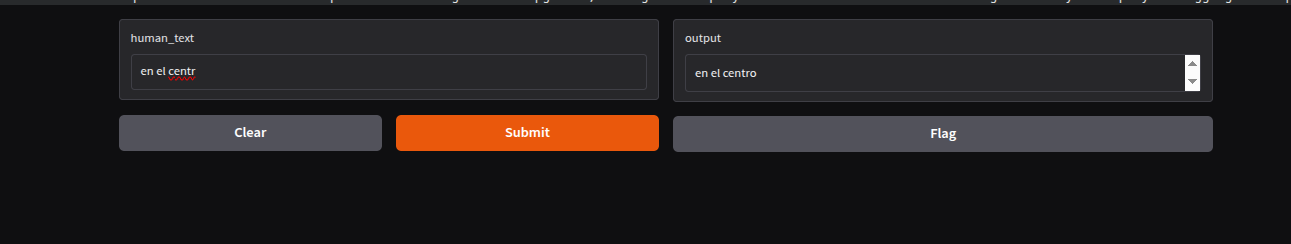

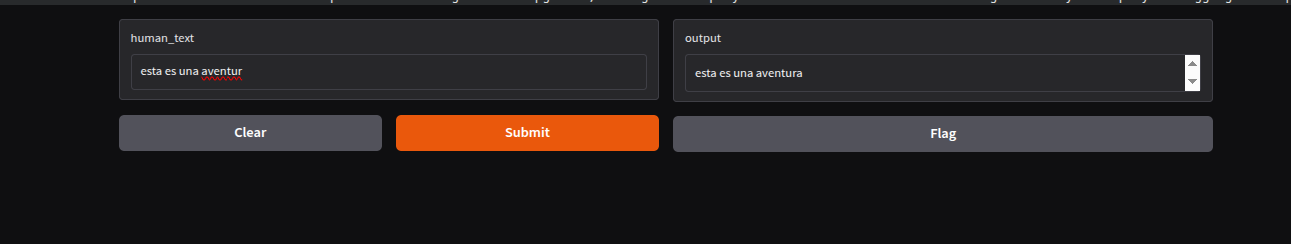

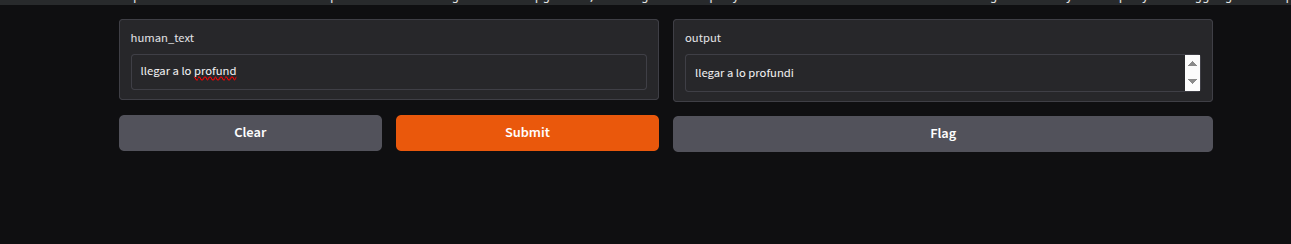


En la mayoria de los casos pudo predecir la siguiente letra.


### **Generación de secuencias**

In [15]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [38]:
input_text='por la tarde intentamos llegar al lugar que'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'por la tarde intentamos llegar al lugar que estaba en el camino de la cab'

In [84]:
input_text='había una vez en'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'había una vez en la cabeza de la cabeza de la '

En esta prueba con la frase en input_text vemos que predice algo coherente

### **Beam search y muestreo aleatorio**

In [25]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [52]:

from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [39]:

# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="por la tarde intentamos llegar al lugar que")

In [40]:

salidas[0]

array([14, 17, 23, 27, 43, 39, 27, 61, 39, 23, 58,  8, 27, 38,  7, 61,  8,
        7, 61, 39, 73, 17,  2, 27, 43, 43,  8, 54, 39, 23, 27, 39, 43, 27,
       43, 34, 54, 39, 23, 27, 16, 34,  8, 27,  7, 17,  2, 27,  8,  7, 44,
       17,  7, 61, 23, 25, 41, 39, 73, 17,  2, 27, 39])

In [41]:

# veamos las salidas
decode(salidas[0])

'por la tarde intentamos llegar al lugar que nos encontrábamos a'

In [85]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="había una vez en")
# veamos las salidas
decode(salidas[0])

'había una vez en el profesor lidenbr'

Si se realizan pruebas con distintas frases las completa con casi lo mismo. Vamos a probar aumentando la temperatura a 1.5

In [69]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="por la tarde intentamos llegar al lugar que", temp=1.5, mode='sto')
# veamos las salidas
decode(salidas[0])

'por la tarde intentamos llegar al lugar que nos perfectamente a'

In [83]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="había una vez en", temp=1.5, mode='sto')
# veamos las salidas
decode(salidas[0])

'había una vez en la tierra que no \nd'